In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [3]:
df1 = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_historical.csv')
df = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_2_8_19.csv')

In [4]:
frames = [df1,df]
df = pd.concat(frames)
del(df1)

In [7]:
def pre_proc(path):

    data = pd.read_csv(path)
    data.columns = [i.lower() for i in data.columns]

    data.rename(index=str,columns={'cuisine description':'cuisine_description',
                                'inspection date':'inspection_date',
                                'critical flag':'critical_flag',
                                'grade date':'grade_date',
                                'record date':'record_date',
                                'inspection type':'inspection_type',
                                'violation code':'violation_code',
                                'violation description':'violation_description'}, inplace=True)


    data['grade_date'] = pd.to_datetime(data['grade_date'],errors='coerce', format='%m/%d/%Y')
    data['inspection_date'] = pd.to_datetime(data['inspection_date'],errors='coerce', format='%m/%d/%Y')
    data['record_date'] = pd.to_datetime(data['record_date'],errors='coerce', format='%m/%d/%Y')

    data['address'] = data['building'] + ' ' + data['street'].str.title()
    data.drop(['building','street'],axis=1, inplace=True)
    data['dba'] = data['dba'].str.title()
    data['boro'] = data['boro'].str.title()


    data['key'] = data['camis']+data['inspection_date']

    data = data.drop_duplicates(['key','violation_code'])


    pending_df = data[data['inspection_date']<'1/1/1901'].copy()
    current_df = data[data['inspection_date']>'1/1/1901'].copy()

    current_df.sort_values(['camis','inspection_date'], ascending=False, inplace=True)
    current_df.reset_index(drop=True,inplace=True)
    
    return [current_df,pending_df]

In [8]:
foo = pre_proc('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_1_30_19.csv')

In [10]:
df = foo[0]

In [6]:
violation_dictionary = {}
for i in range(len(df)):
    current_code = df.loc[i,'violation_code']
    current_desc = df.loc[i,'violation_description']
    
    if current_code not in violation_dictionary:
        violation_dictionary[current_code] = current_desc

In [7]:
violation_df = {}
for i in range(len(df)):
    current_key = df['key'][i]
    current_code = df['violation_code'][i]
    
    if current_key in violation_df:
        violation_df[current_key].append(current_code)
    else:
        violation_df[current_key] = [current_code]
        
codes = []
keys = []
for k,v in violation_df.items():
    keys.append(k)
    codes.append(v)
    
d = {'key':keys,'codes':codes}
insp = pd.DataFrame(d)

In [8]:
df = df.drop_duplicates('key').drop('violation_code',axis=1).drop('violation_description',axis=1).drop('critical_flag',axis=1)
df = df.merge(insp,on='key')


df.sort_values(['camis','inspection_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

df = df[df['inspection_type'].str.contains('Cycle') |
   df['inspection_type'].str.contains('Pre-permit')
  ]

In [9]:
df.reset_index(inplace=True,drop=True)


s1 = []
index = 1

for i in range(len(df)-1):
    current_camis = df['camis'][i]
    next_camis = df['camis'][index]
    
    if current_camis == next_camis:
        time_delt = df['inspection_date'][index] - df['inspection_date'][i]
        s1.append(time_delt)
    else:
        s1.append(pd.NaT)
        
    index += 1
    
s1.append(pd.NaT)
df['time_til'] = pd.Series(s1)

In [10]:
df['event'] = df['time_til'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['time_til'] = df['time_til'].where(pd.notnull(df['time_til']), df['record_date'] - df['inspection_date'])

In [12]:
# df.to_csv('./assets/working_df.csv')

In [11]:
df = pd.read_csv('./assets/working_df.csv')

In [12]:
df['inspection_type'].value_counts()

Cycle Inspection / Initial Inspection                          121176
Cycle Inspection / Re-inspection                                63174
Pre-permit (Operational) / Initial Inspection                   13572
Pre-permit (Operational) / Re-inspection                         7599
Cycle Inspection / Reopening Inspection                          3698
Pre-permit (Non-operational) / Initial Inspection                2939
Pre-permit (Operational) / Reopening Inspection                   772
Cycle Inspection / Compliance Inspection                          728
Pre-permit (Operational) / Compliance Inspection                  597
Pre-permit (Non-operational) / Re-inspection                      286
Pre-permit (Operational) / Second Compliance Inspection            36
Cycle Inspection / Second Compliance Inspection                    20
Pre-permit (Non-operational) / Compliance Inspection               18
Pre-permit (Non-operational) / Second Compliance Inspection         1
Name: inspection_typ

In [ ]:
# time_data = (pd.to_timedelta(df['time_til']).dropna()+pd.to_timedelta(1,unit='s')).astype('timedelta64[D]')

# sns.distplot(time_data);

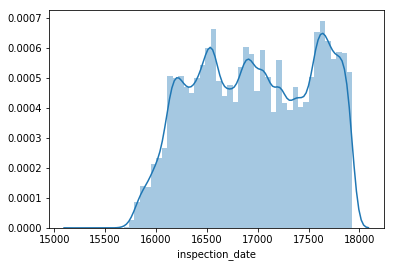

In [83]:
time_data = (pd.to_timedelta(df['inspection_date']).dropna()+pd.to_timedelta(1,unit='s')).astype('timedelta64[D]')

sns.distplot(time_data)

In [155]:
kmf = KaplanMeierFitter()
kmf.fit(df['time_til'].dt.days, df['event'])

kmf.survival_function_
kmf.median_
kmf.plot()

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# grouped = df.groupby(['cuisine_description'])['score'].median().sort_values(ascending=False)

In [29]:
inspection_bin = []

for i in range(len(df)):
    current_type = df.loc[i,'inspection_type']
    current_score = df.loc[i,'score']
    current_camis = df.loc[i,'camis']
    
    if 'Cycle' in current_type:
        if 'Initial' in current_type:
            if current_score < 14:
                inspection_bin.append(0)
            elif current_score > 13:
                inspection_bin.append(1)
                
        elif 'Re-' in current_type:
            previous_score = df.loc[i-1,'score']
            previous_camis = df.loc[i-1,'camis']
            
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append(2)
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append(3)
                elif previous_score > 27:
                    inspection_bin.append(4)
            else:
                inspection_bin.append(np.nan)
        else:
            inspection_bin.append(10)
    elif 'Pre-' in current_type:
        if 'Initial' in current_type:
            if current_score < 14:
                inspection_bin.append(5)
            elif current_score > 13:
                inspection_bin.append(6)
                
        elif 'Re-' in current_type:
            previous_camis = df.loc[i-1,'camis']
            previous_score = df.loc[i-1,'score']
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append(7)
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append(8)
                elif previous_score > 27:
                    inspection_bin.append(9)
            else:
                inspection_bin.append(np.nan)
        else:
            inspection_bin.append(10)
    else:
        inspection_bin.append(10)

In [32]:
inspection_bin = pd.Series(inspection_bin)

In [34]:
df['bin'] = inspection_bin

In [46]:
avg_rest_score = df.groupby(['camis'])['score'].mean()

In [49]:
avg_rest_score[30075445]

9.714285714285714

In [50]:
rest_score = []
for i in df['camis']:
    rest_score.append(avg_rest_score[i])

In [52]:
df['avg_score']=pd.Series(rest_score)

In [61]:
df.drop('Unnamed: 0', axis=1,inplace=True)

In [65]:
df = df.join(pd.get_dummies(df['bin'], drop_first=True))

In [67]:
df.drop('bin',axis=1,inplace=True)

In [80]:
times_closed = df[df['action'].str.contains('Establishment Closed')].groupby(['camis'])['camis'].count()
close_list = []
for i in df['camis']:
    if i in times_closed:
        close_list.append(times_closed[i])
    else:
        close_list.append(0)

In [83]:
df['num_closes'] = pd.Series(close_list)

In [103]:
year_dummies = pd.get_dummies(pd.to_datetime(df['inspection_date']).dt.year,drop_first=True)
df = df.join(year_dummies)

In [104]:
df.columns

Index([              'camis',                 'dba',                'boro',
                   'zipcode',               'phone', 'cuisine_description',
           'inspection_date',              'action',               'score',
                     'grade',          'grade_date',         'record_date',
           'inspection_type',             'address',                 'key',
                     'codes',            'time_til',               'event',
                 'avg_score',                   1.0,                   2.0,
                         3.0,                   4.0,                   5.0,
                         6.0,                   7.0,                   8.0,
                         9.0,                  10.0,          'num_closes',
                        2012,                  2013,                  2014,
                        2015,                  2016,                  2017,
                        2018,                  2019],
      dtype='object')

In [106]:
yes_event = df[df['event']==1].copy()

In [107]:
X = yes_event[[1,2,3,4,5,6,7,8,9,10,'num_closes','avg_score',2012,2013,2014,2015,2016,2017,2018,2019]]
y = yes_event['time_til']

In [128]:
y = y.str.replace(' days 00:00:00.000000000','')

In [134]:
y = y.apply(lambda x: int(x))

In [1]:
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", None)
results = client.get("9w7m-hzhe", where='inspection_date = "1900-01-01T00:00:00.000"')
# client.get_metadata("9w7m-hzhe")
# results = client.get("9w7m-hzhe",limit=20)

In [151]:
df.groupby(['bin'])['time_til']

KeyError: 'bin'

In [5]:
client.get_metadata("9w7m-hzhe")

{'id': '9w7m-hzhe',
 'name': 'DOHMH New York City Restaurant Inspection Results',
 'attribution': 'Department of Health and Mental Hygiene (DOHMH)',
 'averageRating': 0,
 'category': 'Health',
 'createdAt': 1425677589,
 'description': 'The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record.  Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset. \nRecords are also included for each restaurant that has applied for a permit but has not yet been insp

In [2]:
client.get_metadata("9w7m-hzhe")

{'id': '9w7m-hzhe',
 'name': 'DOHMH New York City Restaurant Inspection Results',
 'attribution': 'Department of Health and Mental Hygiene (DOHMH)',
 'averageRating': 0,
 'category': 'Health',
 'createdAt': 1425677589,
 'description': 'The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record.  Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset. \nRecords are also included for each restaurant that has applied for a permit but has not yet been insp

In [8]:
pd.to_datetime(1549486211, unit='s')

Timestamp('2019-02-06 20:50:11')

In [9]:
client.get_metadata("9w7m-hzhe")

{'id': '9w7m-hzhe',
 'name': 'DOHMH New York City Restaurant Inspection Results',
 'attribution': 'Department of Health and Mental Hygiene (DOHMH)',
 'averageRating': 0,
 'category': 'Health',
 'createdAt': 1425677589,
 'description': 'The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record.  Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset. \nRecords are also included for each restaurant that has applied for a permit but has not yet been insp